# Data Exploration and Statistical Analysis of House Price Offers

# 1. Introduction

# 2. Dataset Characteristics

## 2.1. Preparing the Data

In [1]:
import pandas as pd
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float', '{:,.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_info_columns', 50)

In [2]:
house_df = pd.read_csv('Scraped_Data/jabodetabek_house_price.csv')

## 2.2. Dataset Features

#### **Features List**

In [3]:
features = house_df.sample(1).T.rename_axis('features', axis='columns')

features

features,849
url,https://www.rumah123.com/properti/bogor/hos110...
price_in_rp,"1,150,000,000.00"
title,Rumah siap huni Viktoria Sentul city
address,"Sentul City, Bogor"
district,Sentul City
city,Bogor
lat,-6.52
long,106.85
facilities,"Jalur Telepon, Taman, Ac, Jogging Track, Ke..."
property_type,rumah


The feature names are quite understandable and the values are not ambiguous.

#### **Data types of each Features**

We will apply data types of each features accordingly as explained as below:

1. Some features that explains *number of instances* (e.g. number of `garages` provided) is best explained as an integer. For convenience, we will cast the datatypes of those features.

2. Some features fall into *categorical* datatypes (e.g. `certificate`) and some categories naturally have order (e.g. `electricity`)

In [4]:
cast_int_cols_indices = [
    (i, format) for i, format in zip(
        [11, 12, 15, 18, 19, 20, 21, 22, 25], itertools.repeat('Int64')
        )
    ]
cast_categorical_cols_indices = [
    (i, format) for i, format in zip(
        [9, 16, 17, 23, 24, 26], itertools.repeat('category')
        )
    ]
for index, format in (
        cast_int_cols_indices 
        + cast_categorical_cols_indices):
    house_df.iloc[:, index] = house_df.iloc[:, index].astype(format, errors='ignore')
    
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   url                   3553 non-null   object  
 1   price_in_rp           3553 non-null   float64 
 2   title                 3553 non-null   object  
 3   address               3553 non-null   object  
 4   district              3553 non-null   object  
 5   city                  3553 non-null   object  
 6   lat                   3553 non-null   float64 
 7   long                  3553 non-null   float64 
 8   facilities            3553 non-null   object  
 9   property_type         3552 non-null   category
 10  ads_id                3549 non-null   object  
 11  bedrooms              3519 non-null   Int64   
 12  bathrooms             3524 non-null   Int64   
 13  land_size_m2          3551 non-null   float64 
 14  building_size_m2      3551 non-null   float64 
 15  carp

Let's inspect each of the categorical column:

In [5]:
category_columns = \
    house_df.select_dtypes(include='category').columns

for column in category_columns:
    categories = list(house_df[column].dtypes.categories)
    print(column, '. Categories: ', categories, '\n')

property_type . Categories:  ['rumah'] 

certificate . Categories:  ['hgb - hak guna bangunan', 'hp - hak pakai', 'lainnya (ppjb,girik,adat,dll)', 'shm - sertifikat hak milik'] 

electricity . Categories:  ['10000 mah', '10600 mah', '11000 mah', '12700 mah', '1300 mah', '13200 mah', '13300 mah', '13900 mah', '16500 mah', '17600 mah', '2200 mah', '22000 mah', '23000 mah', '24000 mah', '3300 mah', '33000 mah', '3500 mah', '41500 mah', '4400 mah', '450 mah', '47500 mah', '53000 mah', '5500 mah', '6600 mah', '7600 mah', '7700 mah', '8000 mah', '900 mah', '9500 mah', 'lainnya mah'] 

property_condition . Categories:  ['bagus', 'bagus sekali', 'baru', 'butuh renovasi', 'semi furnished', 'sudah renovasi', 'unfurnished'] 

building_orientation . Categories:  ['barat', 'barat daya', 'barat laut', 'selatan', 'tenggara', 'timur', 'timur laut', 'utara'] 

furnishing . Categories:  ['baru', 'furnished', 'semi furnished', 'unfurnished'] 



Several features have mixed record of categories (for example, `property_condition` has furnishing records, so has `furnishing`) and deemed inconsistent for ordering this categories.

We will order the non-ambiguous categories: `certificate` and `electricity`.

1. Certificate categories order shall be: `1) SHM; 2) HGB; 3) HP; 4) lainnya`.
2. Electricity order shall be based on its energy charge

In [6]:
def sort_elect(string_value):
    num_value = re.findall(r'\d+', string_value)
    if len(num_value) == 0:
        return 0
    else:
        return int(num_value[0])

certificate_order = [
    'shm - sertifikat hak milik', 'hgb - hak guna bangunan', 
    'hp - hak pakai', 'lainnya (ppjb,girik,adat,dll)'
    ]
electricity_order = sorted(
    list(house_df['electricity'].dtypes.categories),
    key=sort_elect
    )
house_df['certificate'] = \
    pd.Categorical(
        values=house_df['certificate'],
        categories=certificate_order,
        ordered=True
        )
house_df['electricity'] = \
    pd.Categorical(
        values=house_df['electricity'],
        categories=electricity_order,
        ordered=True
        )

## 2.3. Features with Suspicious Records

Easiest way to detect anomaly in the records is by taking a quick glance in the dataset summary:

In [7]:
house_df.describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
price_in_rp,"3,553.00","4,191,684,773.43","13,750,673,820.54","42,000,000.00","1,500,000,000.00","580,000,000,000.00"
lat,"3,553.00",-6.32,0.13,-6.89,-6.30,-6.10
long,"3,553.00",106.79,0.17,106.40,106.80,109.77
bedrooms,"3,519.00",3.33,2.67,1.00,3.00,99.00
bathrooms,"3,524.00",2.62,2.70,1.00,2.00,99.00
land_size_m2,"3,551.00",204.81,402.13,12.00,108.00,"8,000.00"
building_size_m2,"3,551.00",186.59,248.44,1.00,112.00,"6,000.00"
carports,"3,553.00",1.20,1.11,0.00,1.00,15.00
maid_bedrooms,"3,553.00",0.50,0.69,0.00,0.00,7.00
maid_bathrooms,"3,553.00",0.37,0.54,0.00,0.00,5.00


#### **Price Records**

In [8]:
{"tags": ["hide-input"]}

house_df[['price_in_rp']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
price_in_rp,"3,553.00","4,191,684,773.43","13,750,673,820.54","42,000,000.00","1,500,000,000.00","580,000,000,000.00"


Surely, standard deviation of `price_in_rp` is inflated by a nonproportionally large maximum price records. Currently largest value is Rp. 580 Billion. After inspecting, turns out that in the description, it explains that the price should be Rp. 5.8 Billion.

In [9]:
house_df.loc[house_df.price_in_rp == 580000000000, 'price_in_rp'] = 5800000000
house_df[['price_in_rp']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
price_in_rp,"3,553.00","4,030,074,866.31","9,783,270,716.90","42,000,000.00","1,500,000,000.00","250,000,000,000.00"


After further inspection, there is no other suspicious price that needed to be corrected. 

In later chapter, we will analyze the effect of the price using the more proven statistical approaches such as `outliers detection`, `high leverage observation`, and `cook distance`.

#### **Bedrooms & Bathrooms Records**

In [10]:
{"tags": ["hide-input"]}

house_df[['bedrooms', 'bathrooms']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
bedrooms,"3,519.00",3.33,2.67,1.00,3.00,99.00
bathrooms,"3,524.00",2.62,2.70,1.00,2.00,99.00


In [11]:
pd.DataFrame({
    'count':house_df[['bedrooms']].value_counts().sort_index()
}).T

bedrooms,1,2,3,4,5,6,7,8,9,10,11,12,13,16,20,21,36,37,50,54,57,99
count,19,957,1379,802,218,93,14,10,2,5,2,5,2,2,2,1,1,1,1,1,1,1


In [12]:
{"tags": ["hide-input"]}

pd.DataFrame({
    'count':house_df[['bathrooms']].value_counts().sort_index()
}).T

bathrooms,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,20,21,36,50,54,57,99
count,779,1123,979,446,111,33,20,10,3,3,2,3,1,2,1,2,1,1,1,1,1,1


Simple logic, house with a large amount of bedrooms/bathrooms tends to associated with large building size. House with >= 20 bedrooms may raise suspicion (especially 99!).

In [13]:
large_bedrooms_inst = house_df.loc[
        house_df.bedrooms >= 20, 
        ['url', 'price_in_rp', 'bedrooms', 'land_size_m2', 'building_size_m2', 'floors']
    ].sort_values('bedrooms')

large_bedrooms_inst

,url,price_in_rp,bedrooms,land_size_m2,building_size_m2,floors
2283,https://www.rumah123.com/properti/jakarta-sela...,"26,000,000,000.00",20,915.00,600.00,2
2545,https://www.rumah123.com/properti/jakarta-sela...,"27,000,000,000.00",20,"1,195.00",950.00,2
2282,https://www.rumah123.com/properti/jakarta-sela...,"26,000,000,000.00",21,900.00,700.00,2
346,https://www.rumah123.com/properti/bekasi/hos11...,"9,000,000,000.00",36,939.00,500.00,1
1333,https://www.rumah123.com/properti/bogor/hos109...,"2,700,000,000.00",37,500.00,350.00,1
2483,https://www.rumah123.com/properti/jakarta-sela...,"30,000,000,000.00",50,517.00,"2,417.00",5
2687,https://www.rumah123.com/properti/jakarta-sela...,"28,000,000,000.00",54,890.00,"1,800.00",5
2634,https://www.rumah123.com/properti/jakarta-sela...,"11,800,000,000.00",57,491.00,"1,500.00",4
2888,https://www.rumah123.com/properti/tangerang/ho...,"55,000,000,000.00",99,"1,150.00","6,000.00",4


Turns out that houses with large number of bedrooms is either `boarding house `(*kost*) or `guest house`.

#### **Garages**

In [14]:
{"tags": ["hide-input"]}

house_df[['garages']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
garages,"3,553.00",0.71,1.31,0.00,0.00,50.00


In [15]:
{"tags": ["hide-input"]}

pd.DataFrame({
    'count':house_df[['garages']].value_counts().sort_index()
}).T

garages,0,1,2,3,4,5,6,10,12,20,50
count,1921,1018,519,31,42,6,10,3,1,1,1


Let's inspect house with 50 garages:

In [16]:
large_garages_inst = house_df.loc[
        house_df.garages >= 50, 
        ['url', 'price_in_rp', 'bedrooms', 'land_size_m2', 'building_size_m2', 'floors', 'garages']
    ]

large_garages_inst

,url,price_in_rp,bedrooms,land_size_m2,building_size_m2,floors,garages
2888,https://www.rumah123.com/properti/tangerang/ho...,"55,000,000,000.00",99,"1,150.00","6,000.00",4,50


Turns out that houses with large number of garages is the house with 50 bedrooms i.e. the `boarding house `(*kost*), which explains the provided capacities for vehicle.

## 2.4. Zeroes and Missing Records

#### **Zeroes Records**

Records containing zero values are rather not ambiguous. For example, if `maid_bedrooms = 0`, it explains that this house doesn't provide bedroom for maid. Similar reasoning can safely be applied for other features, except for: `price in rp`, `lat`, `long`, `bedrooms`, `bathrooms`, `lands & building size`, and `floors`.

Let's explore proportion of zeroes records for each feature contains numerical data:

In [17]:
numerical_features = house_df.select_dtypes(exclude=['object', 'category']).columns
total_records = house_df.shape[0]
zeroes = (house_df[numerical_features] == 0).sum()
zeroes_percent = zeroes / total_records * 100
data_types = house_df[numerical_features].dtypes

pd.DataFrame({'Zeroes Count': zeroes, 
    'Zeroes Percentage (%)': zeroes_percent,
    'Data Types': data_types
})

,Zeroes Count,Zeroes Percentage (%),Data Types
price_in_rp,0,0.00,float64
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,Int64
bathrooms,0,0.00,Int64
land_size_m2,0,0.00,float64
building_size_m2,0,0.00,float64
carports,757,21.31,Int64
maid_bedrooms,2078,58.49,Int64
maid_bathrooms,2313,65.10,Int64


Fortunately, primary characteristics of the house doesn't contains zeroes. 

#### **Missing Records**

Let's fist explore missing records for numerical features.

In [18]:
nans = (house_df[numerical_features].isna()).sum()
nans_percent = nans / total_records * 100
data_types = house_df[numerical_features].dtypes

pd.DataFrame({'NaN Count': nans, 
    'NaN Percentage (%)': nans_percent,
    'Data Types': data_types
})

,NaN Count,NaN Percentage (%),Data Types
price_in_rp,0,0.00,float64
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,34,0.96,Int64
bathrooms,29,0.82,Int64
land_size_m2,2,0.06,float64
building_size_m2,2,0.06,float64
carports,0,0.00,Int64
maid_bedrooms,0,0.00,Int64
maid_bathrooms,0,0.00,Int64


Almost half of the dataset contains observations with missing `building_age`, so deducting analysis from this features is not appropriate.

For other features with missing records, it is safe to ignore those observations since they only cover less than 1% of total rows in the dataset.

For categorical and string features:

In [19]:
non_numeric_features = house_df.select_dtypes(include=['object', 'category']).columns
nans = (house_df[non_numeric_features].isna()).sum()
nans_percent = nans / total_records * 100
data_types = house_df[non_numeric_features].dtypes

pd.DataFrame({'NaN Count': nans, 
    'NaN Percentage (%)': nans_percent,
    'Data Types': data_types
})

,NaN Count,NaN Percentage (%),Data Types
url,0,0.00,object
title,0,0.00,object
address,0,0.00,object
district,0,0.00,object
city,0,0.00,object
facilities,0,0.00,object
property_type,1,0.03,category
ads_id,4,0.11,object
certificate,141,3.97,category
electricity,0,0.00,category


Other than `building_orientation`, those features suffers from zero to slightly missing records.

# 3. Data Exploration

## 3.1. Analysis of House Price

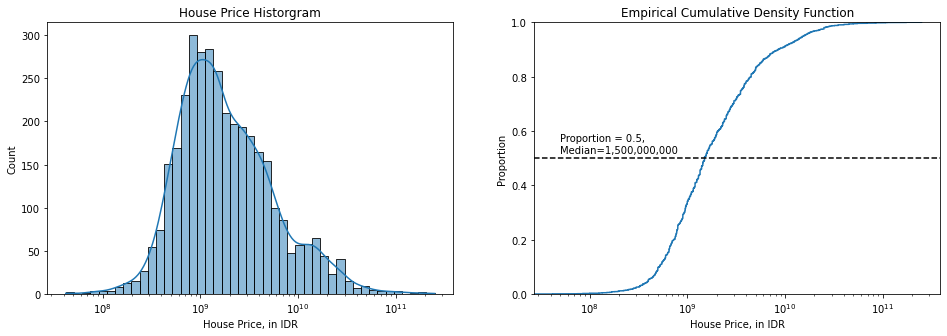

In [82]:
from matplotlib.ticker import FormatStrFormatter

median = house_df['price_in_rp'].median()
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(
    data=house_df, x='price_in_rp', kde=True, 
    log_scale=True, ax=ax[0]
    )
sns.ecdfplot(
    data=house_df, x='price_in_rp', log_scale=True, ax=ax[1]
)
ax[0].set_title('House Price Histogram')
ax[1].axhline(y=0.5, ls='--', color='black')
ax[1].text(x=5*10e6, y=0.52, s=f'Proportion = 0.5,\nMedian={median:,.0f}')
ax[1].set_title('Empirical Cumulative Density Function')
for ax_ in ax:
    ax_.set_xlabel('House Price, in IDR')

In [119]:
for i in median.city:
    print(i)

 Bekasi
 Bogor
 DKI Jakarta
 Depok
 Tangerang


Text(0, 0.5, 'City')

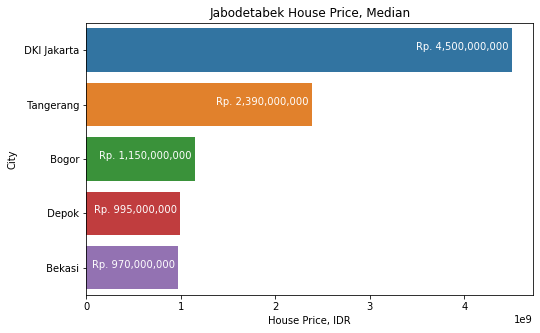

In [142]:
{"tags": ["hide-input"]}

house_df_simple = house_df.copy()
house_df_simple.loc[house_df_simple.city.str.contains('Jakarta'), 'city'] = ' DKI Jakarta'
median = house_df_simple[['city', 'price_in_rp']]\
    .groupby('city')\
    .aggregate(np.median)\
    .reset_index()\
    .sort_values('price_in_rp', ascending=False)
# plot_order = list(median.sort_values('price_in_rp', ascending=False).city)
plt.figure(figsize=(8, 5))
sns.barplot(y='city', x='price_in_rp',data=median)
for y, x in enumerate(median.price_in_rp):
    plt.text(x=x, y=y, s=f'Rp. {x:,.0f} ', ha='right', color='white')
plt.title('Jabodetabek House Price, Median')
plt.xlabel('House Price, IDR')
plt.ylabel('City')


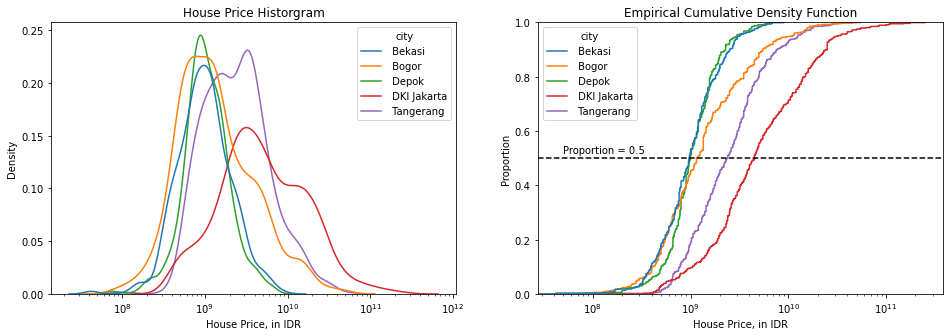

In [94]:
{"tags": ["hide-input"]}

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.kdeplot(
    data=house_df_simple, x='price_in_rp',
    log_scale=True, hue='city', ax=ax[0]
    )
sns.ecdfplot(
    data=house_df_simple, x='price_in_rp', 
    log_scale=True, hue='city', ax=ax[1]
)
ax[0].set_title('House Price Historgram')
ax[1].axhline(y=0.5, ls='--', color='black')
ax[1].text(x=5*10e6, y=0.52, s=f'Proportion = 0.5')
ax[1].set_title('Empirical Cumulative Density Function')
for ax_ in ax:
    ax_.set_xlabel('House Price, in IDR')

# References

1. 'rumah123.com'